In [1]:
%matplotlib inline
import sys
import timeit

sys.path.append('/home/yuhants/ringmap_stats')
from ringmap_statistics import *

## Plot a ringmap and compare it to the template

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['mathtext.default'] = 'regular'

In [3]:
def plot(ringmap, fig=None, pos=None, title = 'Ringmap', extent=None, cmap='RdBu', vmin=-1, vmax=1, ytick=True, ylabel=True, xtick=True, xlabel=True, cbar=True):

    if fig is None:
        fig = plt.figure(figsize = (10,7))
    if pos is None:
        pos = 111
    ax = fig.add_subplot(pos)
    # matplotlib.rcParams.update({'font.size': 40})
    im = ax.imshow(ringmap, aspect = 'auto', vmin=vmin,vmax=vmax,origin='lower', extent=extent, cmap=cmap)
    # plt.plot(RingMap.cyga_pos[0], RingMap.cyga_pos[1], 'yo', markersize = 20, label = 'Cyg A')
    # plt.plot(RingMap.casa_pos[0], RingMap.casa_pos[1], 'go', markersize = 20, label = 'Cas A')
    if cbar:
        cbar = fig.colorbar(im, ax=ax, shrink=1.0)
        cbar.set_label('Jy / Beam', fontsize=20, labelpad=4)
        cbar.ax.tick_params(labelsize=18)

#     ax.legend()
    ax.set_title(title, fontsize=16, pad=10)

    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')

    ax.set_xlabel(r'Right Ascension $(\degree)$', fontsize=20, labelpad=10)
    ax.set_ylabel(r'Declination $(\degree)$', fontsize=20, labelpad=10)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    
    if ylabel == False:
        ax.set_ylabel('')
    if ytick == False:
        ax.set_yticklabels([])
    if xlabel == False:
        ax.set_xlabel('')
    if xtick == False:
        ax.set_xticklabels([])
        
    return (im, ax)

Now we load a ringmap and the template. We use intercylindrical data only (because of data quality), masked it according to Sun, Moon, and the rms, then median subtract it to remove crosstalk.
The best way of removing crosstalk is till an open question. For example, can we median-subtract on RA slices instead of the entire day?

Load a ringmap of a CSD. Load the template (constructued by stacking ringmaps of some "good" days).

In [4]:
lsd_1994 = RingMap(day=1994, intercyl=True)
template = RingMap(median_subtract = True)  # Template already median subtracted

In [5]:
# Mask then median subtract the ringmap (freq idx = 250; 702.34 MHz)
lsd_1994_masked = lsd_1994.get_masked_map(107, median_subtract=False)
lsd_1994_masked_median_subtracted = lsd_1994.get_masked_map(107, median_subtract=True)

Note that the template is median subtracted *before* it is masked. This is different from what we do to ordinary ringmaps, but ensure that each ringmap is compared to the same (median subtracted) template.

In [6]:
# Mask the template in the same way as we do on the ringmap
template_masked_median_subtracted = template.get_masked_map(107, median_subtract=False)
template_masked_median_subtracted.mask = lsd_1994_masked.mask
# template_masked_median_subtracted = template_masked - np.ma.median(template_masked, axis = 1, keepdims = True)

In [7]:
res = lsd_1994_masked_median_subtracted - template_masked_median_subtracted

In [8]:
abs_res = np.square(res)
np.ma.mean(abs_res)

0.08041797825688998

In [9]:
mean = np.ma.mean(res)
std = np.ma.std(res)
print(mean, std)

-0.0003496491244983846 0.2835804224596258


In [10]:
std*std + mean*mean

0.0804179782568901

In [9]:
hist = np.histogram(res.compressed(), range=(-10, 10))

(array([1.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 7.00000e+00,
        3.00000e+00, 4.40000e+01, 8.34771e+05, 2.28000e+02, 1.60000e+01]),
 array([-94.0534013 , -81.89692918, -69.74045706, -57.58398494,
        -45.42751283, -33.27104071, -21.11456859,  -8.95809647,
          3.19837565,  15.35484777,  27.51131989]),
 <BarContainer object of 10 artists>)

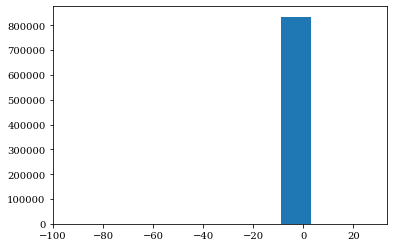

In [10]:
plt.hist(res.compressed(), range=(-10, 10))

In [18]:
# Access frequency and coordinate info
freq_107 =round(lsd_1994.data['index_map']['freq'][107][0], 2)
edges = [lsd_1994.ra[0], lsd_1994.ra[-1], lsd_1994.dec[0], lsd_1994.dec[-1]]

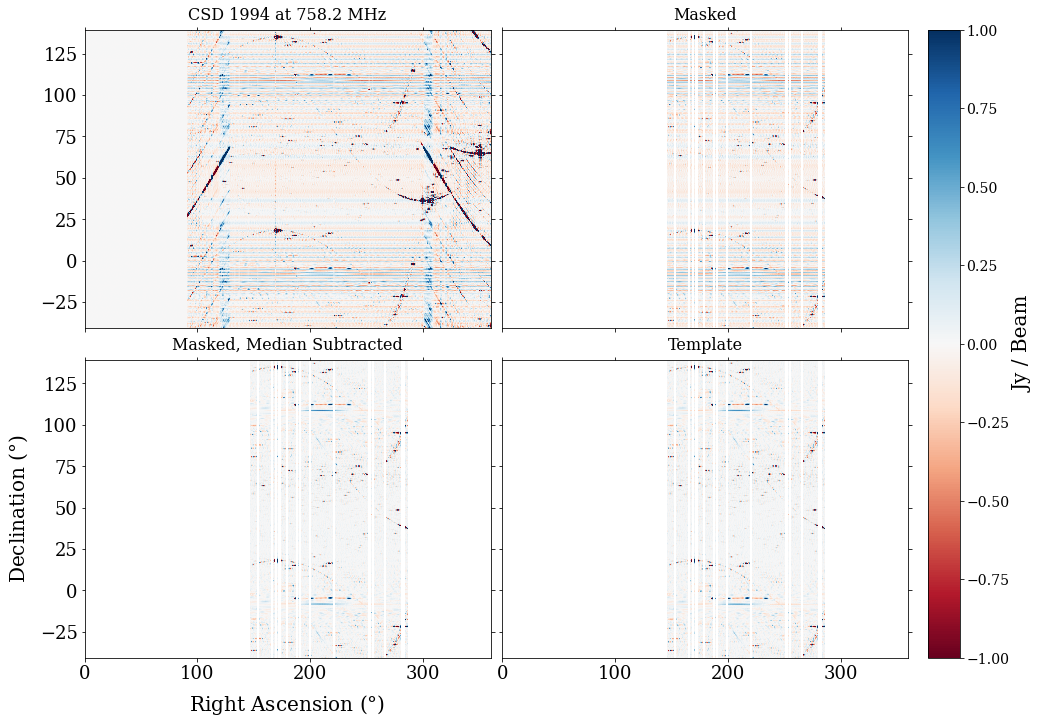

In [11]:
fig = plt.figure(figsize=(15, 10))
im_ax_0 = plot(lsd_1994.ringmap[107], fig, 221, title=f'CSD 1994 at {freq_107} MHz', extent=edges, ytick=True, ylabel=False, xtick=False, xlabel=False, cbar=False)
im_ax_1 = plot(lsd_1994_masked, fig, 222, title=f'Masked', extent=edges, ytick=False, ylabel=False, xtick=False, xlabel=False, cbar=False)
im_ax_2 = plot(lsd_1994_masked_median_subtracted, fig, 223, title=f'Masked, Median Subtracted', extent=edges, ytick=True, ylabel=True, xtick=True, xlabel=True, cbar=False)
im_ax_3 = plot(template_masked_median_subtracted, fig, 224, title=f'Template', extent=edges, ytick=False, ylabel=False, xtick=True, xlabel=False, cbar=False)

fig.tight_layout(pad=0.5)

cbar_0 = fig.colorbar(im_ax_1[0], ax=(im_ax_0[1], im_ax_1[1], im_ax_2[1], im_ax_3[1]), shrink=1.0, pad=0.02)
for cbar in [cbar_0]:
    cbar.set_label('Jy / Beam', fontsize=20, labelpad=4)
    cbar.ax.tick_params(labelsize=14)

## Solar masking

The goal is to understand solar masking and check whether it is doing the right thing.

In [3]:
csd = 1994
lsd = RingMap(day=csd, intercyl=True)

In [13]:
lsd.data['index_map']['freq'][211]

(717.578125, 0.390625)

In [29]:
day_mask = lsd._daytime_mask
moon_mask = lsd._moon_mask
rms_mask = lsd.rms[0, 107, :] != 0  # 107 is the frequency index for 758.2 MHz

Load the timestamps of data. We will check the position of Sun at these moments.

In [30]:
print(lsd.day)
print(lsd.ra)
print(lsd._timestamp) # UNIX time corresponds to each RA

2107
[0.00000000e+00 8.78906250e-02 1.75781250e-01 ... 3.59736328e+02
 3.59824219e+02 3.59912109e+02]
[1.56603705e+09 1.56603707e+09 1.56603709e+09 ... 1.56612315e+09
 1.56612317e+09 1.56612319e+09]


In [31]:
planets = ephemeris.skyfield_wrapper.load('de421.bsp')
chime_obs = ephemeris.chime.skyfield_obs()

earth, sun, moon = planets['earth'], planets['sun'], planets['moon']
time = ephemeris.unix_to_skyfield_time(lsd._timestamp)

In [32]:
astrometric_sun = chime_obs.at(time).observe(sun)
alt, az, d = astrometric_sun.apparent().altaz()
sun_alt = alt.degrees

astrometric_moon = chime_obs.at(time).observe(moon)
moon_alt = astrometric_moon.apparent().altaz()[0].degrees

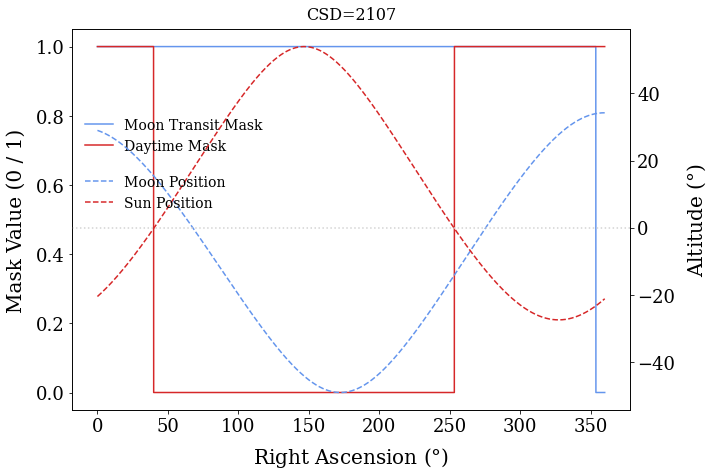

In [33]:
fig, host = plt.subplots(figsize=(10,7))
par1 = host.twinx()

p2 = host.plot(lsd.ra, moon_mask, 'cornflowerblue', label='Moon Transit Mask')
p1 = host.plot(lsd.ra, day_mask, 'tab:red',label='Daytime Mask')
p4 = par1.plot(lsd.ra, moon_alt, 'cornflowerblue', linestyle='--', label='Moon Position')
p3 = par1.plot(lsd.ra, sun_alt, 'tab:red', linestyle='--', label='Sun Position')

host.set_title(f'CSD={csd}', fontsize=16, pad=10)

host.set_xlabel(r'Right Ascension $(\degree)$', fontsize=20, labelpad=10)
host.set_ylabel(r'Mask Value (0 / 1)', fontsize=20, labelpad=10)
host.tick_params(axis='x', labelsize=18)
host.tick_params(axis='y', labelsize=18)
host.legend(frameon=False, loc='upper left', bbox_to_anchor=(0, 0.8), fontsize=14)
par1.set_ylabel(r'Altitude $(\degree)$', fontsize=20, labelpad=10)
par1.tick_params(axis='y', labelsize=18)
par1.legend(frameon=False, loc='upper left', bbox_to_anchor=(0, 0.65), fontsize=14)
par1.axhline(y=0, linestyle='dotted', color='lightgrey')

# plt.plot(timestamp, rms_mask)

In [14]:
from ch_util import ephemeris
from ch_pipeline.analysis import flagging

In [15]:
flagging.daytime_flag(lsd_1994._timestamp) 

array([ True,  True,  True, ...,  True,  True,  True])